In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix,roc_auc_score

from transformers import pipeline

import torch

In [ ]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
classifier("This is my Income")

[{'label': 'POSITIVE', 'score': 0.9958795309066772}]

In [ ]:
classifier([
    "This wad a great meal",
    "I did my best",
    "I failed to attend a class today"
])

[{'label': 'POSITIVE', 'score': 0.9993085861206055},
 {'label': 'POSITIVE', 'score': 0.9996020197868347},
 {'label': 'NEGATIVE', 'score': 0.9996775388717651}]

In [ ]:
airline_tweets = pd.read_csv("Tweets.csv")
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = airline_tweets[["airline_sentiment", "text"]]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Text(0.5, 1.0, 'Number of tweets per sentiment')

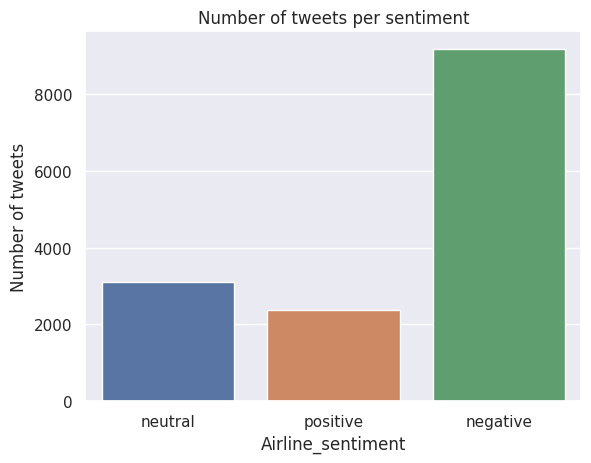

In [ ]:
#sns.countplot(x="airline_sentiment", data=df)
sns.countplot(df, x="airline_sentiment", hue="airline_sentiment")
plt.xlabel("Airline_sentiment")
plt.ylabel("Number of tweets")
plt.title("Number of tweets per sentiment")

In [ ]:
df = df[df['airline_sentiment']!='neutral']
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
df['target'] = df['airline_sentiment'].map({'positive':1, 'negative':0})
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
print("Number of rows:",df.shape[0])

Number of rows: 11541


In [ ]:
texts = df['text'].tolist()
predictions = classifier(texts)
predictions[:5]
# labels = df['target'].tolist()

[{'label': 'POSITIVE', 'score': 0.6070863604545593},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553208947181702}]

In [ ]:
probs = [pred['score'] if pred['label']=='POSITIVE' else 1-pred['score'] for pred in predictions]
probs[:5]

[0.6070863604545593,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553208947181702]

In [ ]:
preds = np.array([1 if pred['label'].startswith('POSITIVE') else 0 for pred in predictions])

In [ ]:
print(f"Accuracy: {round(np.mean(df['target'] ==preds)*100,2)}%")

Accuracy: 88.99%


In [ ]:
confusion = confusion_matrix(df['target'],preds,normalize = 'true')

In [ ]:
def plot_confusion_matrix(confusion_matrix, labels):
  plt.figure(figsize=(8,6))
  sns.set(font_scale =1.4)

  sns.heatmap(confusion_matrix, annot =True, fmt ='g',cmap="Blues",xticklabels = labels, yticklabels=labels)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()


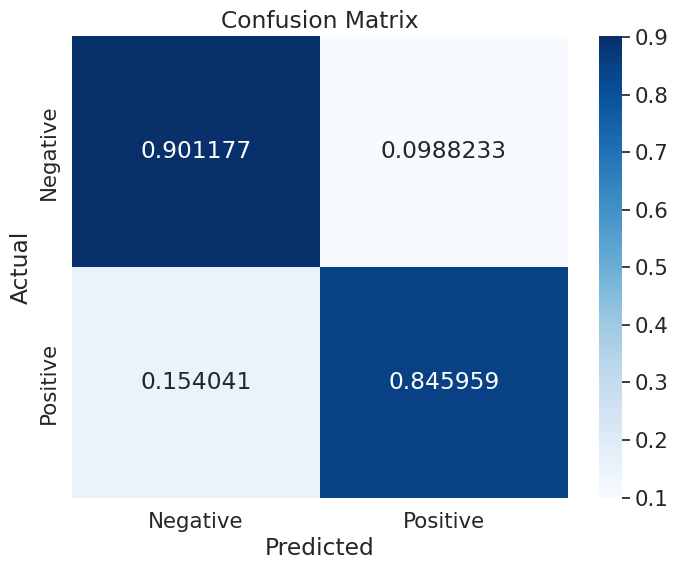

In [ ]:
  plot_confusion_matrix(confusion, ['Negative', 'Positive'])

In [ ]:
print(f"roc auc score: {roc_auc_score(df['target'],probs)}")

roc auc score: 0.9485934921195112
